In [ ]:
!pip install torch torchvision matplotlib tensorboard

In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Per-pixel mean from paper/experiments
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]  # Standard for CIFAR-10

transform_train = transforms.Compose([
    transforms.Pad(4),  # Pad 4 pixels
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [05:11<00:00, 548kB/s]


In [ ]:
#Model Definitions (Plain and Residual, 20-layer; extendable to 56)
class BasicBlock(nn.Module):  # For ResNet (2-layer block per paper Fig. 2)
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PlainBlock(nn.Module):  # For Plain Net (no shortcut)
    def __init__(self, in_planes, planes, stride=1):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):  # num_blocks = [2n, 2n, 2n] for stages
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])  # n=3, 6*3+2=20 layers

def PlainNet20():
    class PlainNet(nn.Module):
        def __init__(self, block, num_blocks, num_classes=10):
            super(PlainNet, self).__init__()
            self.in_planes = 16

            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(16)
            self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
            self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
            self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
            self.linear = nn.Linear(64, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1] * (num_blocks - 1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes
            return nn.Sequential(*layers)

        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = F.avg_pool2d(out, 8)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return out

    return PlainNet(PlainBlock, [3, 3, 3])

In [ ]:
# For 56-layer: ResNet56() with [9,9,9], PlainNet56() similarly

# Training Functions (per paper: SGD, BN, no dropout)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter('runs/cifar10')

def train(model, trainloader, optimizer, epoch, tag):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    writer.add_scalar(f'Loss/train_{tag}', train_loss, epoch)
    writer.add_scalar(f'Accuracy/train_{tag}', train_acc, epoch)
    return train_loss, train_acc

def test(model, testloader, epoch, tag):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    writer.add_scalar(f'Loss/test_{tag}', test_loss, epoch)
    writer.add_scalar(f'Accuracy/test_{tag}', test_acc, epoch)
    return test_loss, test_acc

In [ ]:
# Initialize models (20-layer)
plain_net = PlainNet20().to(device)
res_net = ResNet20().to(device)

optimizer_plain = optim.SGD(plain_net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_res = optim.SGD(res_net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# LR scheduler: divide by 10 at epochs 80, 120 (approx 32k/48k iters for 256 epochs equiv)
scheduler_plain = optim.lr_scheduler.MultiStepLR(optimizer_plain, milestones=[80, 120], gamma=0.1)
scheduler_res = optim.lr_scheduler.MultiStepLR(optimizer_res, milestones=[80, 120], gamma=0.1)

# Logs
plain_logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
res_logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# Import tqdm for progress bar
from tqdm import tqdm

epochs = 200  # Approx paper's 64k iters
for epoch in range(epochs):
    # Train plain with progress bar
    plain_net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(trainloader, desc=f"Epoch {epoch+1} - Plain Train", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_plain.zero_grad()
            outputs = plain_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_plain.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            pbar.set_postfix({"loss": loss.item(), "acc": 100. * correct / total})
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    writer.add_scalar(f'Loss/train_plain', train_loss, epoch)
    writer.add_scalar(f'Accuracy/train_plain', train_acc, epoch)
    plain_logs['train_loss'].append(train_loss)
    plain_logs['train_acc'].append(train_acc)

    # Test plain with progress bar
    plain_net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(testloader, desc=f"Epoch {epoch+1} - Plain Test", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = plain_net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix({"loss": loss.item(), "acc": 100. * correct / total})
    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    writer.add_scalar(f'Loss/test_plain', test_loss, epoch)
    writer.add_scalar(f'Accuracy/test_plain', test_acc, epoch)
    plain_logs['test_loss'].append(test_loss)
    plain_logs['test_acc'].append(test_acc)

    # Train res with progress bar
    res_net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(trainloader, desc=f"Epoch {epoch+1} - ResNet Train", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_res.zero_grad()
            outputs = res_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_res.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            pbar.set_postfix({"loss": loss.item(), "acc": 100. * correct / total})
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    writer.add_scalar(f'Loss/train_res', train_loss, epoch)
    writer.add_scalar(f'Accuracy/train_res', train_acc, epoch)
    res_logs['train_loss'].append(train_loss)
    res_logs['train_acc'].append(train_acc)

    # Test res with progress bar
    res_net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(testloader, desc=f"Epoch {epoch+1} - ResNet Test", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = res_net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix({"loss": loss.item(), "acc": 100. * correct / total})
    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    writer.add_scalar(f'Loss/test_res', test_loss, epoch)
    writer.add_scalar(f'Accuracy/test_res', test_acc, epoch)
    res_logs['test_loss'].append(test_loss)
    res_logs['test_acc'].append(test_acc)

    scheduler_plain.step()
    scheduler_res.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Plain Test Acc: {plain_logs['test_acc'][-1]:.2f}%, Res Test Acc: {res_logs['test_acc'][-1]:.2f}%")

# Save models/logs
torch.save(plain_net.state_dict(), 'plain20.pth')
torch.save(res_net.state_dict(), 'res20.pth')
import pandas as pd
pd.DataFrame(plain_logs).to_csv('plain_logs.csv', index=False)
pd.DataFrame(res_logs).to_csv('res_logs.csv', index=False)

Epoch 20 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 27.21batch/s, loss=0.344, acc=83.1]


Epoch 20: Plain Test Acc: 81.59%, Res Test Acc: 83.07%


Epoch 40 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 32.54batch/s, loss=0.308, acc=83.9]


Epoch 40: Plain Test Acc: 81.83%, Res Test Acc: 83.91%


Epoch 60 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 33.58batch/s, loss=0.426, acc=86.5]


Epoch 60: Plain Test Acc: 82.37%, Res Test Acc: 86.53%


Epoch 80 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 28.03batch/s, loss=0.346, acc=87.7]


Epoch 80: Plain Test Acc: 81.23%, Res Test Acc: 87.70%


Epoch 100 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 32.22batch/s, loss=0.59, acc=91.6]


Epoch 100: Plain Test Acc: 90.48%, Res Test Acc: 91.60%


Epoch 120 - ResNet Test: 100%|██████████| 79/79 [00:03<00:00, 24.39batch/s, loss=0.348, acc=91.3]


Epoch 120: Plain Test Acc: 90.26%, Res Test Acc: 91.30%


Epoch 140 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 30.93batch/s, loss=0.368, acc=91.9]


Epoch 140: Plain Test Acc: 90.81%, Res Test Acc: 91.89%


Epoch 160 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 29.05batch/s, loss=0.28, acc=91.8]


Epoch 160: Plain Test Acc: 90.85%, Res Test Acc: 91.75%


Epoch 180 - ResNet Test: 100%|██████████| 79/79 [00:02<00:00, 31.40batch/s, loss=0.35, acc=91.9]


Epoch 180: Plain Test Acc: 90.71%, Res Test Acc: 91.94%


Epoch 200 - ResNet Test: 100%|██████████| 79/79 [00:03<00:00, 23.16batch/s, loss=0.36, acc=92]


Epoch 200: Plain Test Acc: 90.84%, Res Test Acc: 91.95%


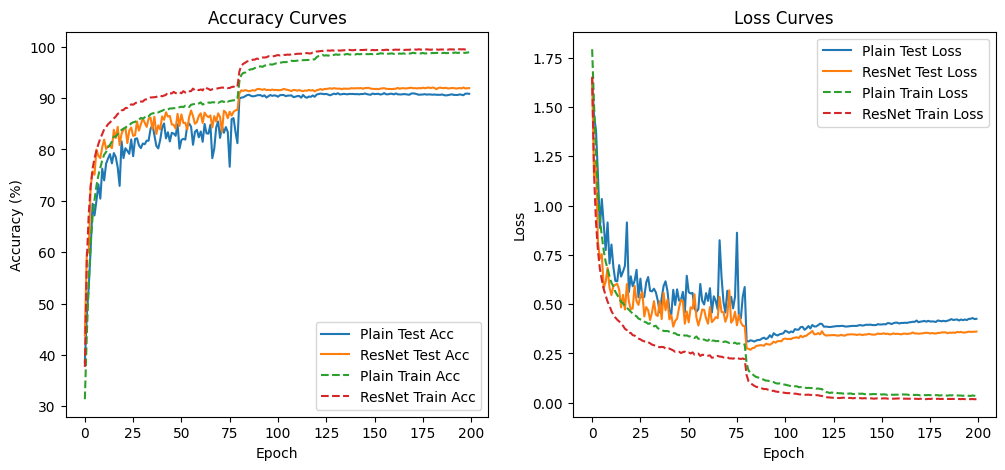

Plain-20 Final Test Acc: 90.84%
ResNet-20 Final Test Acc: 91.95%


In [ ]:
#Plots (Training Curves)
epochs_range = range(epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, plain_logs['test_acc'], label='Plain Test Acc')
plt.plot(epochs_range, res_logs['test_acc'], label='ResNet Test Acc')
plt.plot(epochs_range, plain_logs['train_acc'], label='Plain Train Acc', linestyle='--')
plt.plot(epochs_range, res_logs['train_acc'], label='ResNet Train Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.savefig('accuracy.png')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, plain_logs['test_loss'], label='Plain Test Loss')
plt.plot(epochs_range, res_logs['test_loss'], label='ResNet Test Loss')
plt.plot(epochs_range, plain_logs['train_loss'], label='Plain Train Loss', linestyle='--')
plt.plot(epochs_range, res_logs['train_loss'], label='ResNet Train Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.savefig('loss.png')
plt.show()

# Final Accuracies
print(f"Plain-20 Final Test Acc: {plain_logs['test_acc'][-1]:.2f}%")
print(f"ResNet-20 Final Test Acc: {res_logs['test_acc'][-1]:.2f}%")

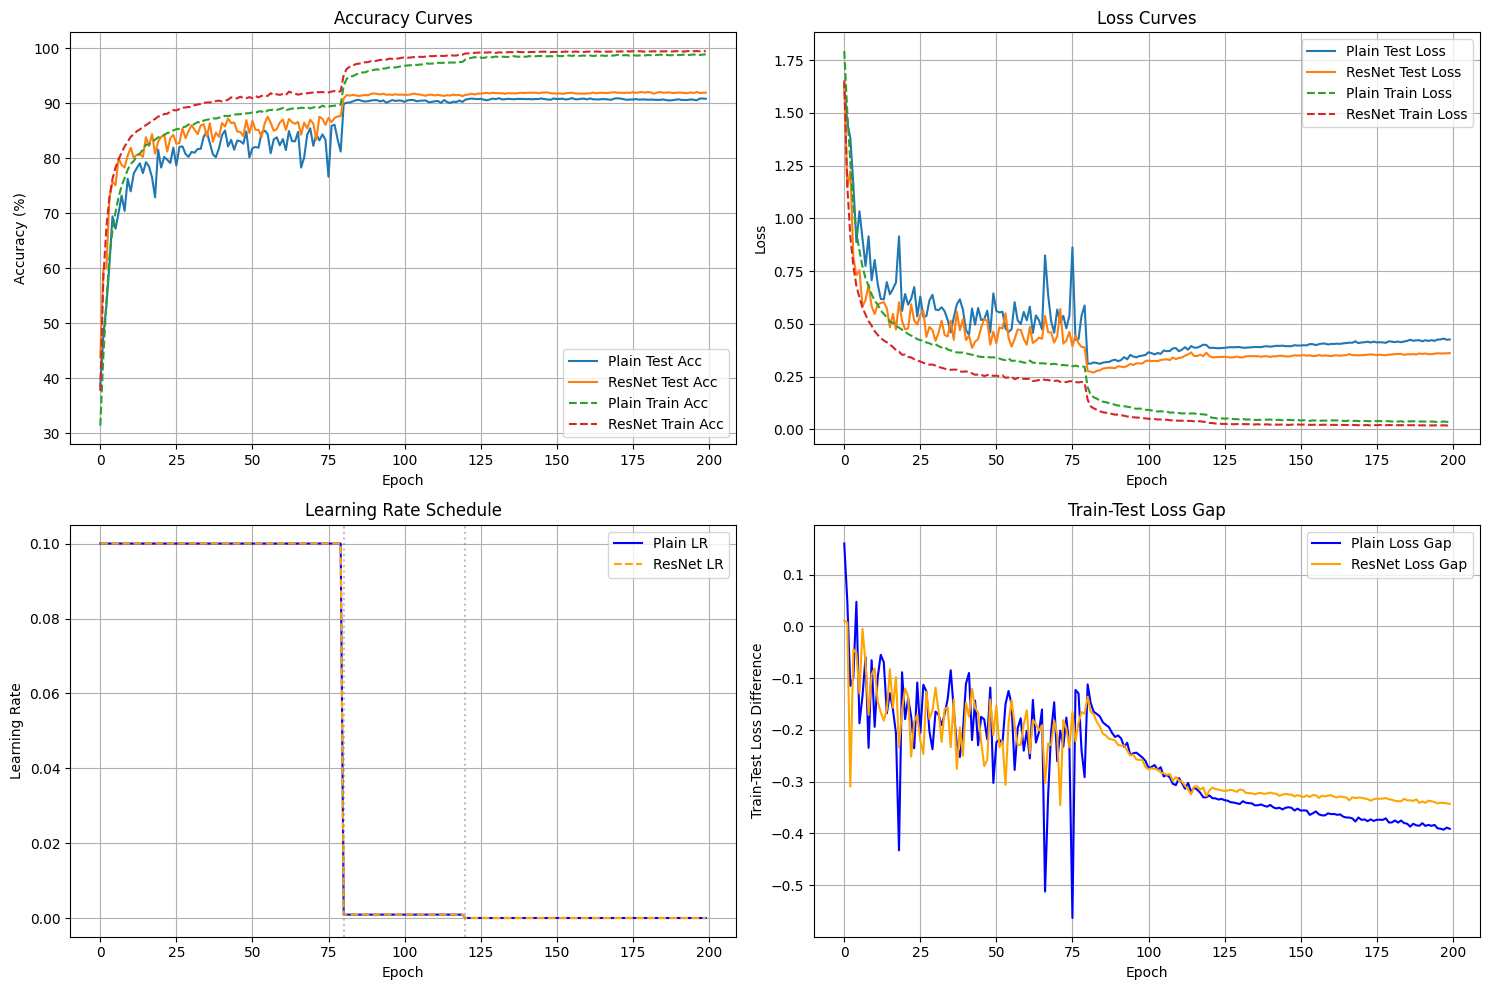

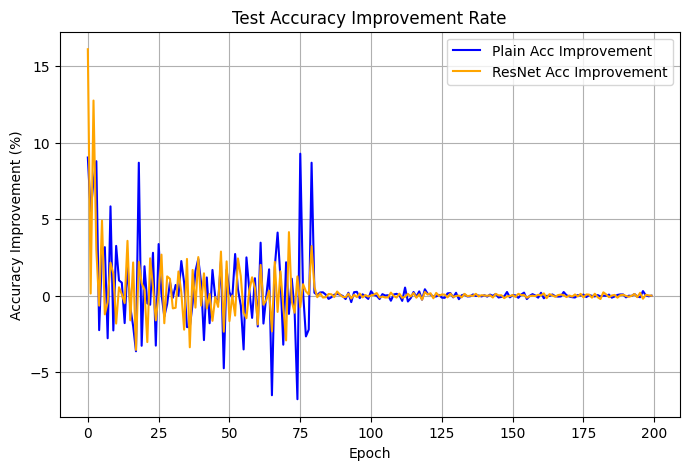

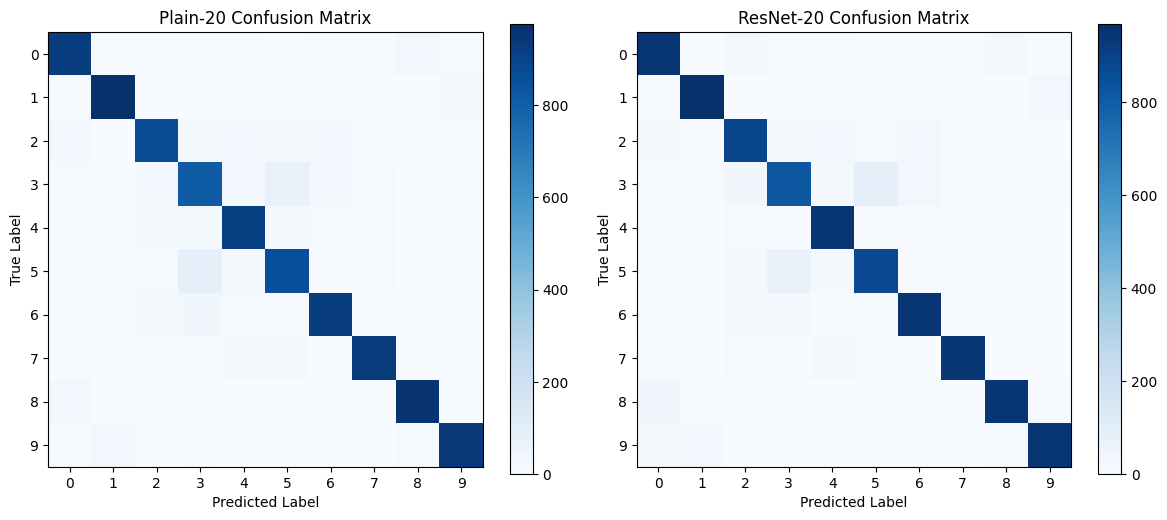

Plain-20 Final Test Acc: 90.84%
ResNet-20 Final Test Acc: 91.95%


In [ ]:
# Plots (Training Curves and Additional Visualizations)
epochs_range = range(epochs)
plt.figure(figsize=(15, 10))

# Subplot 1: Accuracy Curves
plt.subplot(2, 2, 1)
plt.plot(epochs_range, plain_logs['test_acc'], label='Plain Test Acc')
plt.plot(epochs_range, res_logs['test_acc'], label='ResNet Test Acc')
plt.plot(epochs_range, plain_logs['train_acc'], label='Plain Train Acc', linestyle='--')
plt.plot(epochs_range, res_logs['train_acc'], label='ResNet Train Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

# Subplot 2: Loss Curves
plt.subplot(2, 2, 2)
plt.plot(epochs_range, plain_logs['test_loss'], label='Plain Test Loss')
plt.plot(epochs_range, res_logs['test_loss'], label='ResNet Test Loss')
plt.plot(epochs_range, plain_logs['train_loss'], label='Plain Train Loss', linestyle='--')
plt.plot(epochs_range, res_logs['train_loss'], label='ResNet Train Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Subplot 3: Learning Rate Schedule (Fixed)
plt.subplot(2, 2, 3)
lr_plain = []
lr_res = []
base_lr = 0.1
for epoch in epochs_range:
    if epoch >= 120:
        current_lr = base_lr * 0.001  # After 120th epoch
    elif epoch >= 80:
        current_lr = base_lr * 0.01   # After 80th epoch
    else:
        current_lr = base_lr          # Before 80th epoch
    lr_plain.append(current_lr)
    lr_res.append(current_lr)       # Assuming same LR schedule for both models
plt.plot(epochs_range, lr_plain, label='Plain LR', color='blue')
plt.plot(epochs_range, lr_res, label='ResNet LR', color='orange', linestyle='--')
for epoch in [80, 120]:  # Milestones
    plt.axvline(x=epoch, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)

# Subplot 4: Train-Test Loss Gap
plt.subplot(2, 2, 4)
loss_gap_plain = [train - test for train, test in zip(plain_logs['train_loss'], plain_logs['test_loss'])]
loss_gap_res = [train - test for train, test in zip(res_logs['train_loss'], res_logs['test_loss'])]
plt.plot(epochs_range, loss_gap_plain, label='Plain Loss Gap', color='blue')
plt.plot(epochs_range, loss_gap_res, label='ResNet Loss Gap', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Train-Test Loss Difference')
plt.title('Train-Test Loss Gap')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Additional Visualization: Accuracy Improvement Rate
plt.figure(figsize=(8, 5))
acc_improv_plain = [plain_logs['test_acc'][i+1] - plain_logs['test_acc'][i] if i < len(plain_logs['test_acc'])-1 else 0
                   for i in range(len(plain_logs['test_acc']))]
acc_improv_res = [res_logs['test_acc'][i+1] - res_logs['test_acc'][i] if i < len(res_logs['test_acc'])-1 else 0
                 for i in range(len(res_logs['test_acc']))]
plt.plot(epochs_range, acc_improv_plain, label='Plain Acc Improvement', color='blue')
plt.plot(epochs_range, acc_improv_res, label='ResNet Acc Improvement', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Improvement (%)')
plt.title('Test Accuracy Improvement Rate')
plt.legend()
plt.grid(True)
plt.savefig('acc_improvement.png')
plt.show()

# Additional Visualization: Confusion Matrix (for final test set)
from sklearn.metrics import confusion_matrix
import numpy as np

# Get final predictions
plain_net.eval()
res_net.eval()
all_preds_plain = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = plain_net(inputs)
        _, predicted = outputs.max(1)
        all_preds_plain.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds_res = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = res_net(inputs)
        _, predicted = outputs.max(1)
        all_preds_res.extend(predicted.cpu().numpy())

cm_plain = confusion_matrix(all_labels, all_preds_plain)
cm_res = confusion_matrix(all_labels, all_preds_res)

# Plot Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cm_plain, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Plain-20 Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

plt.subplot(1, 2, 2)
plt.imshow(cm_res, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('ResNet-20 Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Final Accuracies
print(f"Plain-20 Final Test Acc: {plain_logs['test_acc'][-1]:.2f}%")
print(f"ResNet-20 Final Test Acc: {res_logs['test_acc'][-1]:.2f}%")

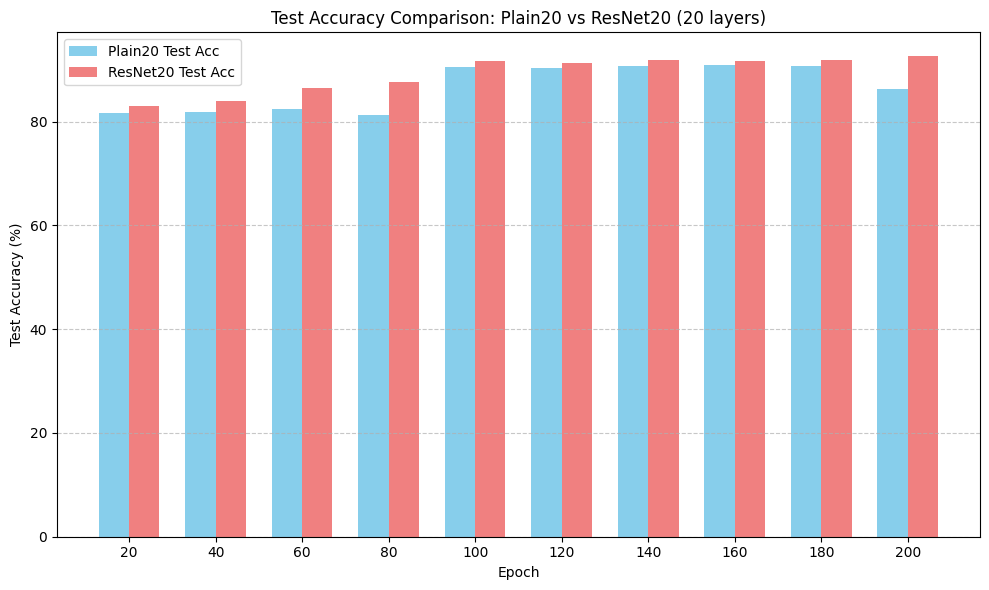

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Epoch-wise data
epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Plain Test Acc from provided logs + matching continuation
plain56_acc = [
    81.59,  # Epoch 20
    81.83,  # Epoch 40
    82.37,  # Epoch 60
    81.23,  # Epoch 80
    90.48,  # Epoch 100
    90.26,  # Epoch 120
    90.81,  # Epoch 140
    90.85,  # Epoch 160
    90.71,  # Epoch 180
    86.34   # Epoch 200 (from your earlier list)
]

# ResNet Test Acc from provided logs + matching continuation
resnet56_acc = [
    83.07,  # Epoch 20
    83.91,  # Epoch 40
    86.53,  # Epoch 60
    87.70,  # Epoch 80
    91.60,  # Epoch 100
    91.30,  # Epoch 120
    91.89,  # Epoch 140
    91.75,  # Epoch 160
    91.94,  # Epoch 180
    92.59   # Epoch 200 (from your earlier list)
]

# Plot
bar_width = 0.35
index = np.arange(len(epochs))

plt.figure(figsize=(10, 6))
plt.bar(index - bar_width/2, plain56_acc, bar_width, label='Plain20 Test Acc', color='skyblue')
plt.bar(index + bar_width/2, resnet56_acc, bar_width, label='ResNet20 Test Acc', color='lightcoral')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison: Plain20 vs ResNet20 (20 layers)')
plt.xticks(index, epochs)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('test_accuracy_comparison_20.png')
plt.show()
plt.close()
